## 使用MLP检测六位二进制数的对称性

[**Learning representations by back-propagating errors.** *David E. Rumelhart, Geoffrey E. Hintont & Ronald J. Williams*](https://www.nature.com/articles/323533a0)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# 生成数据集
def generate_dataset(num_samples):
    """生成数据集，确保对称和非对称样本的平衡

    Args:
        num_samples: 总样本数
    Returns:
        X: 形状为(num_samples, 6)的张量，表示6位二进制数
        y: 形状为(num_samples, 1)的张量，表示是否对称
    """
    # 生成对称样本（约占一半）
    num_symmetric = num_samples // 2
    X_symmetric = torch.zeros((num_symmetric, 6), dtype=torch.float32)

    # 随机生成前3位，后3位镜像复制
    X_symmetric[:, :3] = torch.randint(0, 2, (num_symmetric, 3), dtype=torch.float32)
    for i in range(3):
        X_symmetric[:, 5-i] = X_symmetric[:, i]

    # 生成非对称样本
    num_non_symmetric = num_samples - num_symmetric
    X_non_symmetric = torch.zeros((num_non_symmetric, 6), dtype=torch.float32)

    # 确保生成的样本不是对称的
    for i in range(num_non_symmetric):
        while True:
            x = torch.randint(0, 2, (6,), dtype=torch.float32)
            # 检查是否非对称
            if not (x[0] == x[5] and x[1] == x[4] and x[2] == x[3]):
                X_non_symmetric[i] = x
                break

    # 合并对称和非对称样本
    X = torch.cat([X_symmetric, X_non_symmetric], dim=0)

    # 替换这两行，结果将完全不同
    # y = torch.cat([torch.ones(num_symmetric, 1), torch.zeros(num_non_symmetric, 1)], dim=0)
    y = torch.cat([torch.zeros(num_symmetric, 1), torch.ones(num_non_symmetric, 1)], dim=0)

    # 随机打乱数据
    indices = torch.randperm(num_samples)
    X = X[indices]
    y = y[indices]

    return X, y

In [4]:
# 定义对称检测网络
class SymmetryDetector(nn.Module):
    def __init__(self):
        # super(SymmetryDetector, self).__init__()
        super().__init__()
        # 输入层 -> 隐藏层 (6 -> 2)
        self.hidden = nn.Linear(6, 2)
        # 隐藏层 -> 输出层 (2 -> 1)
        self.output = nn.Linear(2, 1)
        # 激活函数
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 前向传播
        h_linear = self.hidden(x)  # 线性层输出（未经过激活函数）
        h = self.sigmoid(h_linear)  # 经过激活函数的隐藏层
        y = self.sigmoid(self.output(h))
        return y, h, h_linear  # 返回输出、激活后的隐藏层和激活前的隐藏层

In [5]:
# 训练模型
def train_model(model, X_train, y_train, epochs=3000):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    losses = []

    for epoch in range(epochs):
        # 前向传播
        y_pred, _, _ = model(X_train)

        # 计算损失
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印进度
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return losses

在Python编程中，使用单下划线（`_`）作为变量名是一种常见的惯例，表示这个变量是临时的或者你不打算使用这个值。


In [6]:
# 测试模型
def test_model(model, X_test, y_test):
    with torch.no_grad():
        y_pred, hidden_activations, _ = model(X_test)

        # 将预测值转换为二进制（0或1）
        binary_pred = (y_pred > 0.5).float()

        # 计算准确率
        accuracy = (binary_pred == y_test).float().mean()
        print(f'Test Accuracy: {accuracy.item():.4f}')

        return y_pred, hidden_activations

In [7]:
# 可视化隐藏层
def visualize_hidden_layer(model, X):
    with torch.no_grad():
        _, h, h_linear = model(X)  # 获取激活前和激活后的隐藏层值

    # 对称样本
    symmetric_indices = [i for i, x in enumerate(X) if
                         (x[0] == x[5] and x[1] == x[4] and x[2] == x[3])]

    # 非对称样本
    non_symmetric_indices = [i for i in range(len(X)) if i not in symmetric_indices]

    # 创建一个包含两个子图的图形
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制激活前的隐藏层 (h_linear)
    ax = axes[0]
    if symmetric_indices:
        h_linear_symmetric = h_linear[symmetric_indices].numpy()
        ax.scatter(h_linear_symmetric[:, 0], h_linear_symmetric[:, 1], c='blue', label='Symmetric')

    if non_symmetric_indices:
        h_linear_non_symmetric = h_linear[non_symmetric_indices].numpy()
        ax.scatter(h_linear_non_symmetric[:, 0], h_linear_non_symmetric[:, 1], c='red', label='Non-symmetric')

    ax.set_xlabel('Hidden Unit 1 (Pre-activation)')
    ax.set_ylabel('Hidden Unit 2 (Pre-activation)')
    ax.set_title('Hidden Layer Representation (Pre-activation Linear Values)')
    ax.legend()
    ax.grid(True)

    # 绘制激活后的隐藏层 (h)
    ax = axes[1]
    if symmetric_indices:
        h_symmetric = h[symmetric_indices].numpy()
        ax.scatter(h_symmetric[:, 0], h_symmetric[:, 1], c='blue', label='Symmetric')

    if non_symmetric_indices:
        h_non_symmetric = h[non_symmetric_indices].numpy()
        ax.scatter(h_non_symmetric[:, 0], h_non_symmetric[:, 1], c='red', label='Non-symmetric')

    ax.set_xlabel('Hidden Unit 1 (Post-activation)')
    ax.set_ylabel('Hidden Unit 2 (Post-activation)')
    ax.set_title('Hidden Layer Representation (Post-activation Sigmoid Values)')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('hidden_layer_visualization.png')
    plt.show()

In [8]:
# 可视化权重
def visualize_weights(model):
    # 获取输入到隐藏层的权重
    input_weights = model.hidden.weight.data.numpy()

    plt.figure(figsize=(10, 4))

    # 为每个隐藏单元绘制权重
    for i in range(input_weights.shape[0]):
        plt.subplot(1, 2, i+1)
        bars = plt.bar(range(6), input_weights[i])

        # 在每个柱子上方添加具体数值
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{input_weights[i, j]:.3f}',
                    ha='center', va='bottom', rotation=0, fontsize=9)

        plt.title(f'Hidden Unit {i+1} Weights')
        plt.xlabel('Input Units')
        plt.ylabel('Weight Value')
        plt.xticks(range(6))

    plt.tight_layout()
    plt.savefig('weights_visualization.png')
    plt.show()

In [9]:
# 主函数
def main():
    # 生成数据集
    X_train, y_train = generate_dataset(1000)
    X_test, y_test = generate_dataset(100)

    # 创建模型
    model = SymmetryDetector()

    # 训练模型
    losses = train_model(model, X_train, y_train, epochs=75000)

    # 测试模型
    y_pred, hidden_activations = test_model(model, X_test, y_test)

    # 可视化训练过程
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

    # 可视化隐藏层
    visualize_hidden_layer(model, X_test)

    # 可视化权重
    visualize_weights(model)

    # 打印偏置
    print("输入层权重:")
    print(model.hidden.weight.data.numpy())

    print("隐藏层偏置:")
    print(model.hidden.bias.data.numpy())

    print("输出层权重:")
    print(model.output.weight.data.numpy())

    print("输出层偏置:")
    print(model.output.bias.data.numpy())

    # 展示一些例子
    print("\n示例预测:")
    for i in range(5):
        x = X_test[i]
        y = y_test[i]
        pred, _, _ = model(x)
        binary_pred = (pred > 0.5).float()

        print(f"Input: {x.int().numpy()}, Actual: {y.item():.0f}, Predicted: {binary_pred.item():.0f}, Probability: {pred.item():.4f}")

Epoch 500/75000, Loss: 0.6927
Epoch 1000/75000, Loss: 0.6916
Epoch 1500/75000, Loss: 0.6904
Epoch 2000/75000, Loss: 0.6886
Epoch 2500/75000, Loss: 0.6855
Epoch 3000/75000, Loss: 0.6800
Epoch 3500/75000, Loss: 0.6703
Epoch 4000/75000, Loss: 0.6555
Epoch 4500/75000, Loss: 0.6364
Epoch 5000/75000, Loss: 0.6142
Epoch 5500/75000, Loss: 0.5843
Epoch 6000/75000, Loss: 0.5368
Epoch 6500/75000, Loss: 0.4799
Epoch 7000/75000, Loss: 0.4325
Epoch 7500/75000, Loss: 0.3887
Epoch 8000/75000, Loss: 0.3414
Epoch 8500/75000, Loss: 0.3026
Epoch 9000/75000, Loss: 0.2767
Epoch 9500/75000, Loss: 0.2596
Epoch 10000/75000, Loss: 0.2481
Epoch 10500/75000, Loss: 0.2401
Epoch 11000/75000, Loss: 0.2341
Epoch 11500/75000, Loss: 0.2288
Epoch 12000/75000, Loss: 0.2209
Epoch 12500/75000, Loss: 0.1994
Epoch 13000/75000, Loss: 0.1615
Epoch 13500/75000, Loss: 0.1392
Epoch 14000/75000, Loss: 0.1246
Epoch 14500/75000, Loss: 0.1125
Epoch 15000/75000, Loss: 0.1018
Epoch 15500/75000, Loss: 0.0923
Epoch 16000/75000, Loss: 0.0

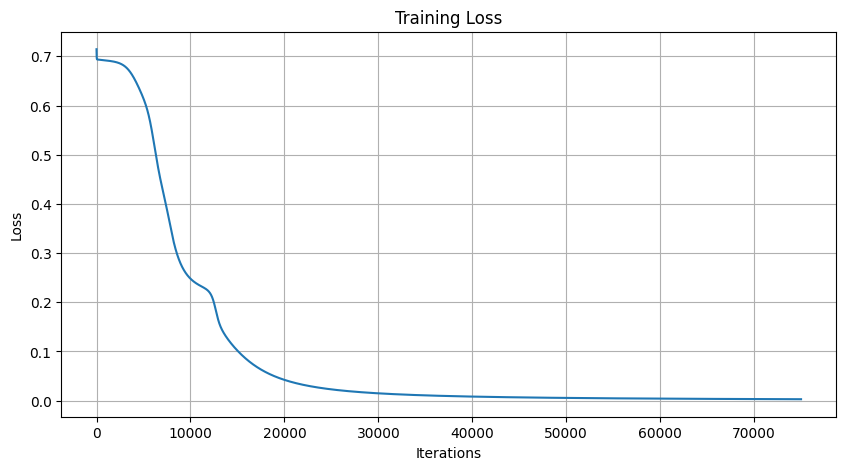

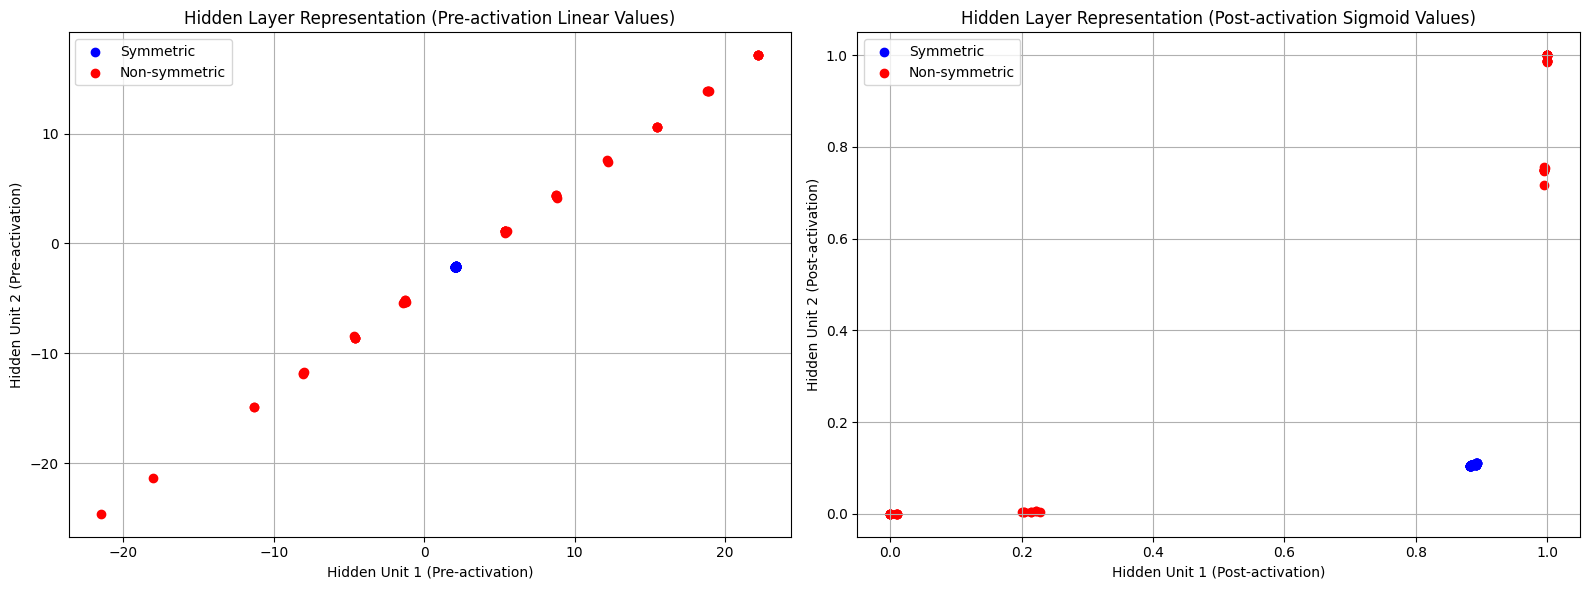

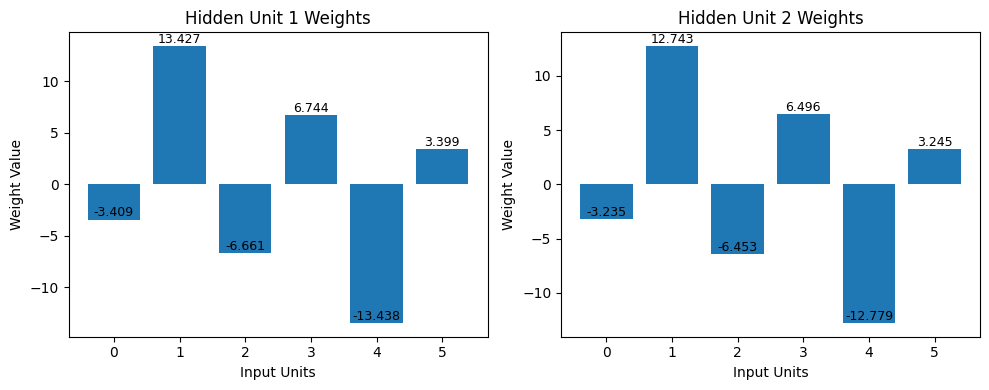

输入层权重:
[[ -3.4092603  13.426815   -6.660585    6.743984  -13.438093    3.3990955]
 [ -3.2352338  12.7431755  -6.453001    6.495504  -12.778698    3.2450545]]
隐藏层偏置:
[ 2.0420272 -2.126966 ]
输出层权重:
[[-17.9044    19.181816]]
输出层偏置:
[7.9622645]

示例预测:
Input: [0 0 1 1 1 0], Actual: 1, Predicted: 1, Probability: 0.9997
Input: [0 1 0 1 0 0], Actual: 1, Predicted: 1, Probability: 0.9999
Input: [1 1 1 0 1 0], Actual: 1, Predicted: 1, Probability: 0.9996
Input: [0 1 1 0 0 1], Actual: 1, Predicted: 1, Probability: 0.9999
Input: [1 1 1 1 1 1], Actual: 0, Predicted: 0, Probability: 0.0027


In [10]:
main()

In [11]:
# 对于第一个隐藏单元的权重

print(13.703 / 3.506) # 约等于 4
print(6.850 / 3.506)  # 约等于 2

3.9084426697090704
1.9537934968625215


In [12]:
# 对于第二个隐藏单元的权重

print(12.713 / 3.220) # 约等于 4
print(6.421 / 3.220)  # 约等于 2

3.9481366459627325
1.9940993788819876
